### Project 5: Worm Algorithm for the 6-Vertex Model (Monte Carlo)

Date: <span style = "color: wheat"> 28.05.2025 </span> | Author of the code: <span style = "color: wheat"> Matthias Pawlik </span>

Implement the worm algorithm discussed in the lecture for the 6-vertex model (https://en.wikipedia.org/wiki/Ice-type_model) at infinite temperature, where all allowed configurations are equally likely. Calculate the correlation function $\langle s_0 s_r \rangle \propto 1/r^a$ and extract the decay exponent $a$.

In [196]:
# Import of libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [201]:
# Definition of the ice-type model
class six_vertex_model(object):
    """Ice-type (6-vertex) model class with periodic boundary conditions.
    
    Attributes
    ----------
    Lx : int
        Lattice X size.
    Ly : int
        Lattice Y size.
    N : int
        Number of vertices.
    lattice : list
        Horizontal (hor) & vertical (ver) sublattices.
        Shape: ((Ly, Lx), (Lx, Ly))

    Methods
    -------
    - plot()
    - get_vertex_in_out(x, y)
    - get_vertex_charge(x, y)
    - get_next_vertex(x, y, flip)
    - flip_spin(x, y, flip)
    - flip_next_spin(x, y, flip)
    - check_valid_config()
    - propagate_2_defects()
    - thermalize(N)
    - fancy_plot()
    - measure_correlations()
    
    """

    def __init__(self, Lx, Ly, hor=[], ver=[]):
        """ hor, ver: initial lattice configuration.
        """
        self.Lx = Lx
        self.Ly = Ly
        self.N = Lx * Ly

        assert Lx == Ly # Square lattice for fast numpy manipulations

        # Assume periodic boundary conditions (OBC)
        # hor[_][0] = hor[_][Lx+1] and ver[_][0] = ver[_][Ly+1]
        if hor == [] or ver == []:
            hor = np.ones((Ly, Lx), dtype = np.int8)
            ver = np.ones((Lx, Ly), dtype = np.int8)
            # Initial state: alternate spins from line to line
            hor[1::2] *= -1
            ver[1::2] *= -1
            self.lattice = np.array([hor, ver]) # shape: ((Ly, Lx), (Lx, Ly))
        else:
            assert hor.shape == (Ly, Lx) and ver.shape == (Lx, Ly)
            self.lattice = np.array([hor, ver]) # shape: ((Ly, Lx), (Lx, Ly))
            self.check_valid_config()

    def plot(self):
        """ Plot hor & ver sublattices ('ver' transposed for graphical purposes).
        """
        print('Horizontal spins:')
        print(self.lattice[0], '\n')
        print('Vertical spins:')
        print(self.lattice[1].transpose(), '\n')


    def get_vertex_in_out(self, x, y):
        """ Return spin values: np.array([spin_left, spin_right, spin_up, spin_down]) relative to vertex (x, y).
        Ingoing  : +1
        Outgoing : -1
        """
        spin_left  = self.lattice[0, x, y]
        spin_right = self.lattice[0, x, (y+1) % self.Lx] * -1
        spin_up    = self.lattice[1, y, x] * -1
        spin_down  = self.lattice[1, y, (x+1) % self.Ly]
        return np.array([spin_left, spin_right, spin_up, spin_down])


    def get_vertex_charge(self, x, y):
        """ Return magnetic charge of vertex (x, y).
        """
        return np.sum(self.get_vertex_in_out(x, y)) / 2
    

    def get_next_vertex(self, x, y, flip):
        """ Return coordinates of neighbor vertex in the flip direction and flip relative to that vertex.
        x, y : 1st vertex coordinates
        flip : Flip directions (left: 0), (right: 1), (up: 2), (down: 3)
        """
        if flip == 0:   # left
            return x, (y-1) % self.Lx, 1
        elif flip == 1: # right
            return x, (y+1) % self.Lx, 0
        elif flip == 2: # up
            return (x-1) % self.Ly, y, 3
        else:           # down
            return (x+1) % self.Ly, y, 2
        
    
    def flip_spin(self, x, y, flip):
        """ Create 2 defects by flipping 1 spin.
        x, y : Vertex coordinates
        flip : Flip directions (left: 0), (right: 1), (up: 2), (down: 3)
        """
        if flip == 0:   # left
            self.lattice[0, x, y] *= -1
        elif flip == 1: # right
            self.lattice[0, x, (y+1) % self.Lx] *= -1
        elif flip == 2: # up
            self.lattice[1, y, x] *= -1
        else:           # down
            self.lattice[1, y, (x+1) % self.Ly] *= -1


    def flip_next(self, x, y, flipped):
        """ Propagate defect by flipping randomly one of the other spins of the vertex, subject to the ice rule (2-in, 2-out).
        Return next vertex coordinates & new flip relative to that vertex.
        x, y    : Vertex coordinates
        flipped : Flip directions (left: 0), (right: 1), (up: 2), (down: 3)
        """
        in_or_out = self.get_vertex_in_out(x, y)
        flipped_dir = in_or_out[flipped] # in: 1, out: -1
        
        in_or_out[flipped] = 0 # Remove old direction from possibilities
        possible = np.arange(4)[in_or_out == flipped_dir] # 2 new flip directions
  
        flip_new = -1
        prob = np.random.random() # 50/50 chance
        if prob < 0.5:
            flip_new = possible[0]
        else:
            flip_new = possible[1]

        self.flip_spin(x, y, flip_new)
        return self.get_next_vertex(x, y, flip_new)
    

    def propagate_2_defects(self):
        """ Flip 1 spin, create 2 defective vertices & propagate one randomly until they meet & annihilate each other.
        """
        x = np.random.randint(self.Lx) # vertex x coordinate
        y = np.random.randint(self.Ly) # vertex y coordinate
        flip = np.random.randint(4) # left: 0, right: 1, up: 2, down: 3
        
        self.flip_spin(x, y, flip)
        xf, yf, _ = self.get_next_vertex(x, y, flip) # end vertex coordinates (x_f, y_f)
        
        propagate = True
        while propagate:
            x, y, flip = self.flip_next(x, y, flip)
            if (x, y) == (xf, yf): # defects meet & annihilate
                propagate = False


    def thermalize(self, N=1000):
        """ Thermalize system by running 'propagate_2_defects' N times.
        """
        for _ in range(N):
            self.propagate_2_defects()

        
    def check_valid_config(self):
        """ Check if system respects the ice rule (2-in, 2-out).
        Return number of defects (charged vertices).
        """
        charged = 0
        for x in range(self.Ly):
            for y in range(self.Lx):
                if self.get_vertex_charge(x, y) != 0:
                    charged += 1

        if charged == 0:
            print('6-vertex configuration is valid. No finite-charge vertices.')
        else:
            print('6-vertex configuration is not valid!', charged, 'finite-charge vertices.')

    
    def fancy_plot(self, figsize=(8,8)):
        """ Plot the lattice with arrows for each spin at every vertex.
        Ingoing  : blue arrow
        Outgoing : purple arrow
        """

        fig, ax = plt.subplots(figsize = figsize)
        ax.set_aspect('equal')
        ax.set_xlim(-0.5, self.Lx-0.5)
        ax.set_ylim(-0.5, self.Ly-0.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_facecolor('lightgray')

        # Arrow properties
        arrowprops = dict(width=0.03, head_width=0.13, head_length=0.13, length_includes_head=True)
        color_in = 'steelblue'
        color_out = 'purple'
        r = 0.45

        for x in range(self.Ly):
            for y in range(self.Lx):
                # Draw tile
                rect = patches.Rectangle((y-0.5, x-0.5), 1, 1, linewidth=0.5, edgecolor='gray', facecolor='none')
                ax.add_patch(rect)

                # Get spin directions for this vertex
                spin_left, spin_right, spin_up, spin_down = self.get_vertex_in_out(x, y)

                cx, cy = y, x # Center of tile

                # Left arrow
                if spin_left == 1: # in
                    ax.arrow(cx - r, cy, r, 0, color=color_in, **arrowprops)
                else: # out
                    ax.arrow(cx, cy, -r, 0, color=color_out, **arrowprops)

                # Right arrow
                if spin_right == 1: # in
                    ax.arrow(cx + r, cy, -r, 0, color=color_in, **arrowprops)
                else: # out
                    ax.arrow(cx, cy, r, 0, color=color_out, **arrowprops)

                # Up arrow
                if spin_up == 1: # in
                    ax.arrow(cx, cy - r, 0, r, color=color_in, **arrowprops)
                else: # out
                    ax.arrow(cx, cy, 0, -r, color=color_out, **arrowprops)

                # Down arrow
                if spin_down == 1: # in
                    ax.arrow(cx, cy + r, 0, -r, color=color_in, **arrowprops)
                else: # out
                    ax.arrow(cx, cy, 0, r, color=color_out, **arrowprops)

        plt.title('Spin Configuration 6-Vertex Model')
        plt.show()

    
    def measure_correlations(self, corr='all'):

        """ Measure spin correlations with distance on square lattice.
        Errors are decreased using translational & rotational invariance.
                
        Return (corr == 'all'):
            1) corr_hor_hor : horizontal   correlations of horizontal spins. Size: L - 1
            2) corr_ver_ver : vertical     correlations of vertical   spins. Size: L - 1
            3) corr_ver_hor : vertical     correlations of horizontal spins. Size: L - 1
            4) corr_hor_ver : horizontal   correlations of vertical   spins. Size: L - 1
            5) corr_diag1   : diagonal     correlations.                     Size: 2 * L - 1
            6) corr_diag2   : antidiagonal correlations.                     Size: 2 * L - 1
            
        Due to rotational invariance:
        - 1) & 2) should be the same.
        - 3) & 4) should be the same.
        - 5) & 6) should be the same.
        
        Return (corr == 'rot_invar'):
            - corr_along : correlations along spin direction.            Size: L - 1
            - corr_perp  : correlations perpendicular to spin direction. Size: L - 1
            - corr_diag  : diagonal correlations.                        Size: 2 * L - 1
        """

        assert self.Lx == self.Ly # Square lattice
        L = self.Lx

        corr_hor_hor = np.empty((L, L - 1))
        corr_ver_ver = np.empty((L, L - 1))
        corr_ver_hor = np.empty((L, L - 1))
        corr_hor_ver = np.empty((L, L - 1))
        corr_diag1  = np.zeros((L, 2*L - 1))
        corr_diag2  = np.zeros((L, 2*L - 1))

        for i in range(L):
            corr_hor_hor[i] = np.sum(self.lattice[0, :, i, np.newaxis] *
                                    self.lattice[0, :, np.r_[i+1:L, :i]].transpose(), 0)
            corr_ver_ver[i] = np.sum(self.lattice[1, :, i, np.newaxis] *
                                    self.lattice[1, :, np.r_[i+1:L, :i]].transpose(), 0)

            corr_ver_hor[i] = np.sum(self.lattice[0, i] *
                                    self.lattice[0, np.r_[i+1:L, :i]], 1)
            corr_hor_ver[i] = np.sum(self.lattice[1, i] *
                                    self.lattice[1, np.r_[i+1:L, :i]], 1)
            
            # Diagonal correlations
            for k in range(L):
                # Diagonals
                spin_origin, _, _, spin_origin2 = self.get_vertex_in_out((i+k) % L, k)
                corr_diag1[i, 0] += spin_origin * spin_origin2
                corr_diag1[i,-1] += spin_origin2 * spin_origin
                
                # Antidiagonals
                spin_antiorigin, _, spin_antiorigin2, _ = self.get_vertex_in_out((i-k) % L, k)
                corr_diag2[i, 0] += spin_antiorigin * -spin_antiorigin2
                corr_diag2[i,-1] += -spin_antiorigin2 * spin_antiorigin

                for j in range(1, L):
                    spin_left, _, _, spin_down = self.get_vertex_in_out((i+k+j) % L, (k+j) % L)
                    corr_diag1[i, 2*j-1] += spin_origin * spin_left
                    corr_diag1[i, 2*j]   += spin_origin * spin_down
                    corr_diag1[i, 2*j-2] += spin_origin2 * spin_left
                    corr_diag1[i, 2*j-1] += spin_origin2 * spin_down
            
                    spin_left, _, spin_up, _ = self.get_vertex_in_out((i-k-j) % L, (k+j) % L) 
                    corr_diag2[i, 2*j-1] += spin_antiorigin * spin_left
                    corr_diag2[i, 2*j]   += spin_antiorigin * -spin_up
                    corr_diag2[i, 2*j-2] += -spin_antiorigin2 * spin_left
                    corr_diag2[i, 2*j-1] += -spin_antiorigin2 * -spin_up
        
        if corr == 'all': # Separate for initial comparison
            corr_hor_hor = np.sum(corr_hor_hor, 0) / (L * L)
            corr_ver_ver = np.sum(corr_ver_ver, 0) / (L * L)
            corr_ver_hor = np.sum(corr_ver_hor, 0) / (L * L)
            corr_hor_ver = np.sum(corr_hor_ver, 0) / (L * L)
            corr_diag1  = np.sum(corr_diag1, 0)  / (L * 2*L)
            corr_diag2  = np.sum(corr_diag2, 0)  / (L * 2*L)
        
            return corr_hor_hor, corr_ver_ver, corr_ver_hor, corr_hor_ver, corr_diag1, corr_diag2
        
        elif corr == 'rot_invar': # Average due to invariance
            corr_along = np.sum(corr_hor_hor + corr_ver_ver, 0) / (2 * L * L)
            corr_perp  = np.sum(corr_ver_hor + corr_hor_ver, 0) / (2 * L * L)
            # Need absolute value here due to:
            # opposite correlations in diagonals & antidiagonals 
            # between spins with perpendicular directions
            corr_diag  = np.sum(np.abs(corr_diag1) + np.abs(corr_diag2), 0) / (2 * L * 2*L)
            
            return corr_along, corr_perp, corr_diag

6-vertex configuration is valid. No finite-charge vertices.


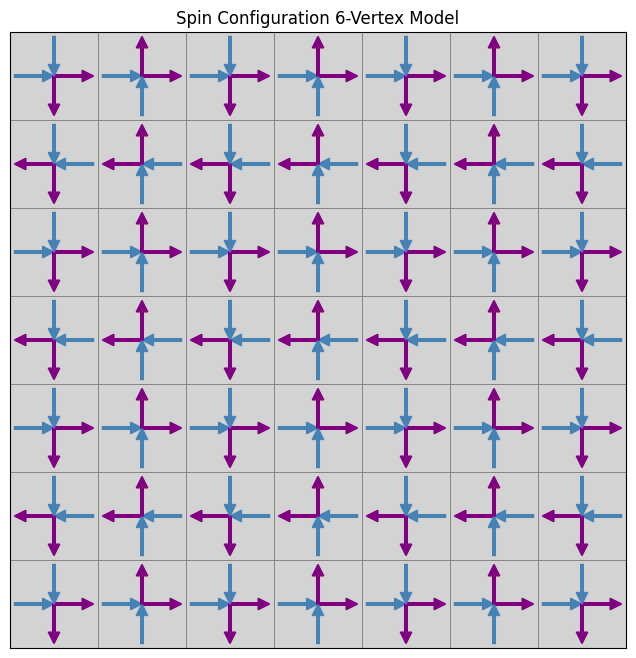

In [203]:
model = six_vertex_model(Lx = 7, Ly = 7)
model.check_valid_config()
model.fancy_plot()

In [204]:
# Simulate ice-type model with defect
def run_worm_simulation(Lx, Ly, Niter, corr_type='all'):
    """ Run worm algorithm on 6-vertex model.
    Return (corr_type == 'all'):       correlations list (shape: (Niter, 6))
    Return (corr_type == 'rot_invar'): correlations list (shape: (Niter, 3))
    """
    icetype = six_vertex_model(Lx, Ly)
    corrs = []
    
    icetype.thermalize(Niter//10)
    for _ in range(Niter):
        icetype.propagate_2_defects()
        corrs.append(icetype.measure_correlations(corr_type))
    return corrs

In [ ]:
# Testing area
Ls = [10] #, 20, 30, 40, 50]
params = {
    10: {'Ni': 1000, 'Nbins': 20},
    20: {'Ni': 1000, 'Nbins': 20}, 
    30: {'Ni': 1000, 'Nbins': 20},
    40: {'Ni': 1000, 'Nbins': 20},
    50: {'Ni': 500,  'Nbins': 10}
}

corrs = []
corrs_avg = []

"""
corrs             : list  of Ls       lists
corrs[_]          : list  of Niter    tuples
corrs[_][_]       : tuple of 3/6      arrays
corrs[_][_][_]    : array of L-1/2L-1 floats
corrs[_][_][_][_] : float

and similar shape for corrs_avg
"""

# Run worm algorithm & get correlations
for i, L in enumerate(Ls):
    print(f"Progress: L = {L} ({i / len(Ls) * 100:.2f}) %", end="\r", flush=True)
    Ni = params[L]['Ni']
    Nbins = params[L]['Nbins']
    Niter = Ni * Nbins
    corrs.append(run_worm_simulation(L, L, Niter, corr_type='all'))
    
    # Binning analysis
    corrs_avg.append([])
    for j in range(Nbins):
        corrs_avg[i].append(np.sum(corrs[-1][j*Ni:(j+1)*Ni], 0) / Ni)

# Mean correlations
corrs_avg = np.array(corrs_avg) # shape: (Ls, Nbins, 3/6 corr types)
corrs_avg_hor_hor = np.sum(corrs_avg[:, :, 0], 1) / Nbins # shape: (Ls, L-1 floats)
corrs_avg_ver_ver = np.sum(corrs_avg[:, :, 1], 1) / Nbins
corrs_avg_ver_hor = np.sum(corrs_avg[:, :, 2], 1) / Nbins
corrs_avg_hor_ver = np.sum(corrs_avg[:, :, 3], 1) / Nbins
corrs_avg_diag1  = np.sum(corrs_avg[:, :, 4], 1) / Nbins # shape: (Ls, 2L-1 floats)
corrs_avg_diag2  = np.sum(corrs_avg[:, :, 5], 1) / Nbins

corrs_avg_along = np.sum(corrs_avg[:, :, 0] +
                       corrs_avg[:, :, 1], 1) / (2 * Nbins) # shape: (Ls, L-1 floats)
corrs_avg_prep  = np.sum(corrs_avg[:, :, 2] +
                       corrs_avg[:, :, 3], 1) / (2 * Nbins)
corrs_avg_diag  = np.sum(np.abs(corrs_avg[:, :, 4]) +
                       np.abs(corrs_avg[:, :, 5]), 1) / (2 * Nbins) # shape: (Ls, 2L-1 floats)

# Standard deviations. maybe should divide by sqrt(Ni) instead?
err_avg_hor_hor = np.array([np.std(corrs_avg[i, :, 0]) for i in range(len(Ls))]) / np.sqrt(Nbins)
err_avg_ver_ver = np.array([np.std(corrs_avg[i, :, 1]) for i in range(len(Ls))]) / np.sqrt(Nbins)
err_avg_ver_hor = np.array([np.std(corrs_avg[i, :, 2]) for i in range(len(Ls))]) / np.sqrt(Nbins)
err_avg_hor_ver = np.array([np.std(corrs_avg[i, :, 3]) for i in range(len(Ls))]) / np.sqrt(Nbins)
err_avg_diag1  = np.array([np.std(corrs_avg[i, :, 4]) for i in range(len(Ls))]) / np.sqrt(Nbins)
err_avg_diag2  = np.array([np.std(corrs_avg[i, :, 5]) for i in range(len(Ls))]) / np.sqrt(Nbins)

err_avg_along = np.array([np.std((corrs_avg[i, :, 0] +
                                 corrs_avg[i, :, 1]) / 2) for i in range(len(Ls))]) / np.sqrt(Nbins)
err_avg_prep  = np.array([np.std((corrs_avg[i, :, 2] +
                                 corrs_avg[i, :, 3]) / 2) for i in range(len(Ls))]) / np.sqrt(Nbins)
err_avg_diag  = np.array([np.std((np.abs(corrs_avg[i, :, 4]) + np.abs(corrs_avg[i, :, 5])) / 2)
                         for i in range(len(Ls))]) / np.sqrt(Nbins)

# Save correlations & erros to files
for i in range(len(Ls)):
    np.savez('data/L%s_N%s_%sx%sbins_all.npz' % (Ls[i], Niter, Ni, Nbins),
             corrs=[corrs_avg_hor_hor[0], corrs_avg_ver_ver[0], corrs_avg_ver_hor[0],
                    corrs_avg_hor_ver[0], corrs_avg_diag1[0], corrs_avg_diag2[0]],
             errs=[err_avg_hor_hor[0], err_avg_ver_ver[0], err_avg_ver_hor[0],
                   err_avg_hor_ver[0], err_avg_diag1[0], err_avg_diag2[0]])
    
    np.savez('data/L%s_N%s_%sx%sbins_final.npz' % (Ls[i], Niter, Ni, Nbins),
             corrs=[corrs_avg_along[0], corrs_avg_prep[0], corrs_avg_diag[0]],
             errs=[err_avg_along[0], err_avg_prep[0], err_avg_diag[0]])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (1, 20, 6) + inhomogeneous part.